In [ ]:

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive')
import pickle

In [ ]:
!cp drive/MyDrive/plot_utils.py .
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.4.1


In [ ]:
!cp '/content/drive/MyDrive/face.zip' .
!unzip -q face.zip
!rm face.zip

In [ ]:
import os
from pathlib import Path
import glob
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array

In [ ]:
#design the generator model
num_features = 100
 
generator = keras.models.Sequential([
    keras.layers.Dense(4 * 4 * 1024, input_shape=[num_features]),
    keras.layers.Reshape([4, 4, 1024]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1024, (4,4),(2,2), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(512, (4,4), (2,2), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(512, (4,4), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(256, (4,4),(2,2), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(256, (4,4), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, (4,4),(2,2), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (4,4), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(3, (3,3), activation='tanh', padding='same'),
])
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1654784   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1024)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 1024)        4096      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 1024)        16778240  
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 1024)        4096      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 512)       8389120   
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 512)       2

In [ ]:
#create discriminator layer
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[64, 64, 3]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(256, (5,5), (2,2), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(512, (5,5), (2,2), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(1024, (5,5), (2,2), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
#define optimization function and compile discrimainator and gan
from keras.optimizers import Adam
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001,decay_steps=500000, decay_rate=0.95)
opt1=Adam(
    learning_rate=0.0002,
    beta_1=0.5,
    )
'''opt2=Adam(
    learning_rate=0.0005,
    beta_1=0.5,
    beta_2=0.7,
    epsilon=1e-03,
    amsgrad=True,
    )
  '''
discriminator.compile(loss="binary_crossentropy", optimizer=opt1)
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer= opt1)

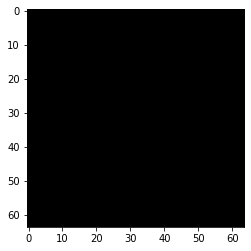

In [ ]:
#before training the output of he generator
noise = tf.random.normal(shape=[1, num_features])
generated_images = generator(noise, training=False)
gen_image=np.squeeze(generated_images)
plt.imshow(np.squeeze(gen_image.astype('int8')))

In [ ]:
input_dir  = Path('/content/face')
train_images = sorted(os.listdir(input_dir))
print("Total number of images in the training set: ", len(train_images))

Total number of images in the training set:  3318


In [ ]:
#create list of images from training directory
x_train=[]
 
 
for img in train_images:
    img = load_img(input_dir / img,target_size=(64,64))
    img = img_to_array(img).astype('float32')/255.
    x_train.append(img)

In [ ]:
#convert image into numpy array
x_train= np.array(x_train)
print("Size of X : ", x_train.shape)

Size of X :  (3318, 64, 64, 3)


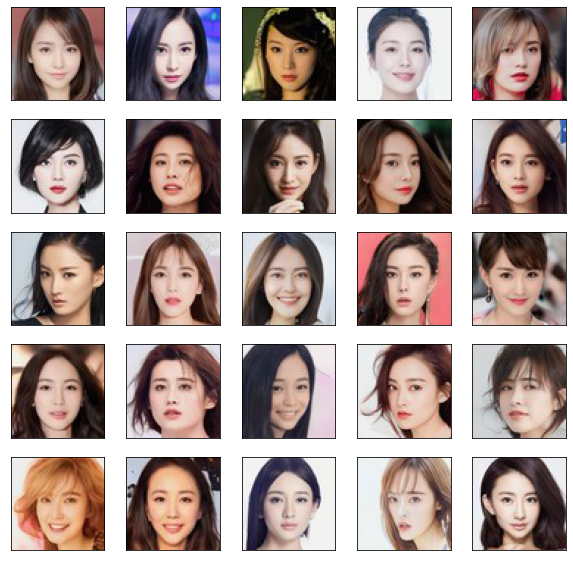

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((x_train[i]))
plt.show()

In [ ]:
decision = discriminator(generated_images)
print(decision)

tf.Tensor([[0.50000143]], shape=(1, 1), dtype=float32)


In [ ]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    b_size=int((batch_size)/2)
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise,training=False)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.1]] * batch_size +[[0.9]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[(2*batch_size), num_features])
            y2 = tf.constant([[1]] * (2*batch_size))
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            # Produce images for the GIF as we go
            seed = tf.random.normal(shape=[b_size, 100])
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        #filename = '/content/drive/MyDrive/gen/generator_model_%03d.h5' % (epoch+1)
        #generator.save(filename)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(6,6))
 
  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(np.clip(predictions[i],0,1 ))
      plt.axis('off')
 
  plt.savefig('/content/drive/MyDrive/savedimages/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
x_train_dcgan = x_train.reshape(-1, 64, 64, 3) * 2. - 1.
x_train_dcgan.shape

(3318, 64, 64, 3)

In [ ]:
#batching of dataset to make training faster
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
%%time
#train and save models
train_dcgan(gan, dataset, batch_size, num_features, epochs=200)
gan.save('/content/drive/MyDrive/models/facesynthesis11')
generator.save('/content/drive/MyDrive/models/facesynthesis_generator11')

In [ ]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
plot_utils.show(generated_images, 8)

In [ ]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/drive/MyDrive/savedimages/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
display.Image(filename=anim_file)

In [ ]:
#loading on of the finest generaor model obtained during traing 
new_model = tf.keras.models.load_model('/content/drive/MyDrive/models/facesynthesis_generator')

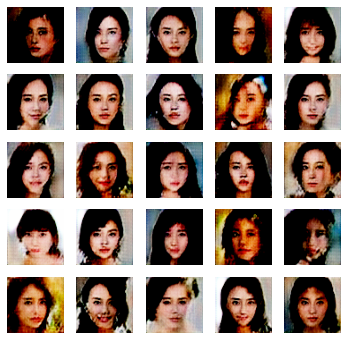

In [ ]:
noise = tf.random.normal(shape=[25, num_features])
generated_images = new_model(noise)
fig = plt.figure(figsize=(6,6))
for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(np.clip(generated_images[i],0,1 ))
      plt.axis('off')
plt.savefig('/content/drive/MyDrive/savedimages/image_at_epoch_{:04d}.png'.format(309))
plt.show()